In \[1\]:

    pwd

Out\[1\]:

    'C:\\Users\\sudeepb'

In \[2\]:

    import pandas as pd
    # read data
    reviews_df = pd.read_csv("Hotel_Reviews.csv")
    # append the positive and negative text reviews
    reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
    # create the label
    reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
    # select only relevant columns
    reviews_df = reviews_df[["review", "is_bad_review"]]
    reviews_df.head()

Out\[2\]:

|     | review                                            | is_bad_review |
|-----|---------------------------------------------------|---------------|
| 0   | I am so angry that i made this post available...  | 1             |
| 1   | No Negative No real complaints the hotel was g... | 0             |
| 2   | Rooms are nice but for elderly a bit difficul...  | 0             |
| 3   | My room was dirty and I was afraid to walk ba...  | 1             |
| 4   | You When I booked with your company on line y...  | 0             |

In \[3\]:

    reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)

In \[4\]:

    # remove 'No Negative' or 'No Positive' from text
    reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In \[5\]:

    import nltk

    # Download WordNet data
    nltk.download('wordnet')

    # Download stopwords data
    nltk.download('stopwords')

    # Download punkt tokenizer data (if not already downloaded)
    nltk.download('punkt')

    [nltk_data] Downloading package wordnet to
    [nltk_data]     C:\Users\sudeepb\AppData\Roaming\nltk_data...
    [nltk_data]   Package wordnet is already up-to-date!
    [nltk_data] Downloading package stopwords to
    [nltk_data]     C:\Users\sudeepb\AppData\Roaming\nltk_data...
    [nltk_data]   Package stopwords is already up-to-date!
    [nltk_data] Downloading package punkt to
    [nltk_data]     C:\Users\sudeepb\AppData\Roaming\nltk_data...
    [nltk_data]   Package punkt is already up-to-date!

Out\[5\]:

    True

In \[8\]:

    from nltk.corpus import wordnet

    def get_wordnet_pos(pos_tag):
        if pos_tag.startswith('J'):
            return wordnet.ADJ
        elif pos_tag.startswith('V'):
            return wordnet.VERB
        elif pos_tag.startswith('N'):
            return wordnet.NOUN
        elif pos_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
        
    import string
    from nltk import pos_tag
    from nltk.corpus import stopwords
    from nltk.tokenize import WhitespaceTokenizer
    from nltk.stem import WordNetLemmatizer

    def clean_text(text):
        # lower text
        text = text.lower()
        # tokenize text and remove puncutation
        text = [word.strip(string.punctuation) for word in text.split(" ")]
        # remove words that contain numbers
        text = [word for word in text if not any(c.isdigit() for c in word)]
        # remove stop words
        stop = stopwords.words('english')
        text = [x for x in text if x not in stop]
        # remove empty tokens
        text = [t for t in text if len(t) > 0]
        # pos tag text
        pos_tags = pos_tag(text)
        # lemmatize text
        text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
        # remove words with only one letter
        text = [t for t in text if len(t) > 1]
        # join all
        text = " ".join(text)
        return(text)

    # clean text data
    reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

In \[7\]:

    nltk.download('averaged_perceptron_tagger')

    [nltk_data] Downloading package averaged_perceptron_tagger to
    [nltk_data]     C:\Users\sudeepb\AppData\Roaming\nltk_data...
    [nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.

Out\[7\]:

    True

In \[11\]:

    from nltk.sentiment.vader import SentimentIntensityAnalyzer

    sid = SentimentIntensityAnalyzer()
    reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
    reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

In \[10\]:

    nltk.download('vader_lexicon')

    [nltk_data] Downloading package vader_lexicon to
    [nltk_data]     C:\Users\sudeepb\AppData\Roaming\nltk_data...

Out\[10\]:

    True

In \[13\]:

    # add number of characters column
    reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

    # add number of words column
    reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))# create doc2vec vector columns
    from gensim.test.utils import common_texts
    from gensim.models.doc2vec import Doc2Vec, TaggedDocument

    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

    # train a Doc2Vec model with our text data
    model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

    # transform each document into a vector data
    doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
    doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
    reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In \[15\]:

    from sklearn.feature_extraction.text import TfidfVectorizer
    import pandas as pd

    # Create a TfidfVectorizer
    tfidf = TfidfVectorizer(min_df=10)

    # Fit and transform the text data
    tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()

    # Create a DataFrame with TF-IDF values and feature names
    tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf.get_feature_names_out())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = reviews_df.index

    # Concatenate the TF-IDF DataFrame with the original DataFrame
    reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In \[16\]:

    reviews_df.head()

Out\[16\]:

|        | review                                           | is_bad_review | review_clean                                      | neg   | neu   | pos   | compound | nb_chars | nb_words | doc2vec_vector_0 | ... | word_yet | word_yoghurt | word_yogurt | word_young | word_yr | word_yummy | word_zero | word_ziggo | word_zone | word_zuid |
|--------|--------------------------------------------------|---------------|---------------------------------------------------|-------|-------|-------|----------|----------|----------|------------------|-----|----------|--------------|-------------|------------|---------|------------|-----------|------------|-----------|-----------|
| 488440 | Would have appreciated a shop in the hotel th... | 0             | would appreciate shop hotel sell drinking wate... | 0.049 | 0.617 | 0.334 | 0.9924   | 599      | 113      | -0.088069        | ... | 0.0      | 0.0          | 0.0         | 0.0        | 0.0     | 0.0        | 0.0       | 0.0        | 0.0       | 0.0       |
| 274649 | No tissue paper box was present at the room      | 0             | tissue paper box present room                     | 0.216 | 0.784 | 0.000 | -0.2960  | 44       | 10       | 0.018188         | ... | 0.0      | 0.0          | 0.0         | 0.0        | 0.0     | 0.0        | 0.0       | 0.0        | 0.0       | 0.0       |
| 374688 | Pillows Nice welcoming and service               | 0             | pillow nice welcome service                       | 0.000 | 0.345 | 0.655 | 0.6908   | 36       | 7        | 0.040035         | ... | 0.0      | 0.0          | 0.0         | 0.0        | 0.0     | 0.0        | 0.0       | 0.0        | 0.0       | 0.0       |
| 404352 | Everything including the nice upgrade The Hot... | 0             | everything include nice upgrade hotel revamp s... | 0.000 | 0.621 | 0.379 | 0.9153   | 155      | 27       | -0.084062        | ... | 0.0      | 0.0          | 0.0         | 0.0        | 0.0     | 0.0        | 0.0       | 0.0        | 0.0       | 0.0       |
| 451596 | Lovely hotel v welcoming staff                   | 0             | lovely hotel welcome staff                        | 0.000 | 0.230 | 0.770 | 0.7717   | 32       | 7        | -0.005496        | ... | 0.0      | 0.0          | 0.0         | 0.0        | 0.0     | 0.0        | 0.0       | 0.0        | 0.0       | 0.0       |

5 rows × 3840 columns

In \[17\]:

    #EDA

In \[18\]:

    reviews_df["is_bad_review"].value_counts(normalize = True)

Out\[18\]:

    0    0.956761
    1    0.043239
    Name: is_bad_review, dtype: float64

In \[19\]:

    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    def show_wordcloud(data, title = None):
        wordcloud = WordCloud(
            background_color = 'white',
            max_words = 200,
            max_font_size = 40, 
            scale = 3,
            random_state = 42
        ).generate(str(data))

        fig = plt.figure(1, figsize = (20, 20))
        plt.axis('off')
        if title: 
            fig.suptitle(title, fontsize = 20)
            fig.subplots_adjust(top = 2.3)

        plt.imshow(wordcloud)
        plt.show()
        
    # print wordcloud
    show_wordcloud(reviews_df["review"])

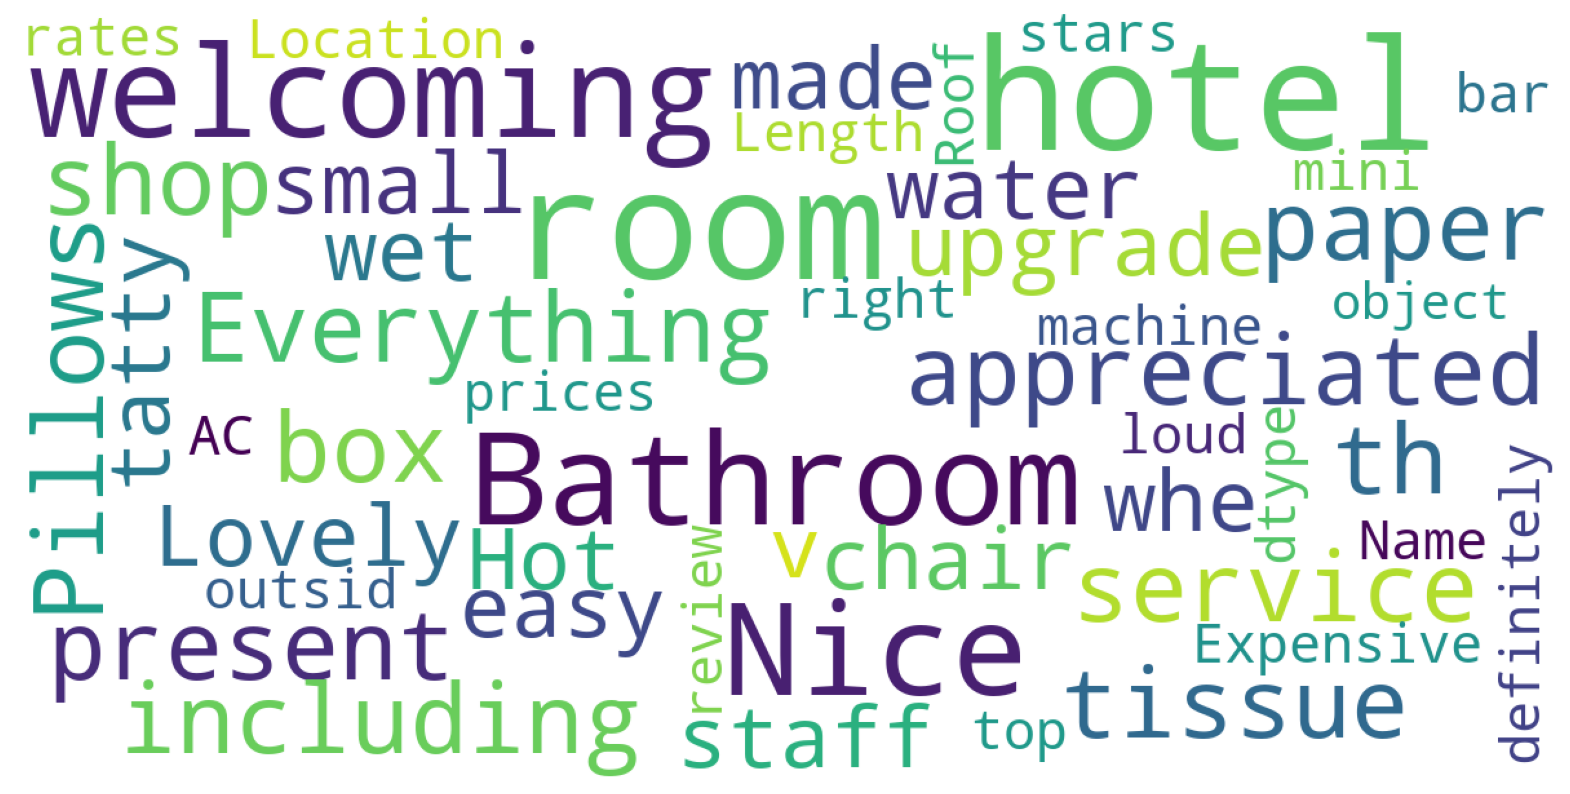

In \[20\]:

    reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

Out\[20\]:

|        | review                                     | pos   |
|--------|--------------------------------------------|-------|
| 43101  | A perfect location comfortable great value | 0.931 |
| 211742 | Clean comfortable lovely staff             | 0.907 |
| 175551 | Friendly welcome Comfortable room          | 0.905 |
| 365085 | Good location great value                  | 0.904 |
| 109564 | Clean friendly and comfortable             | 0.902 |
| 145743 | Good value amazing location                | 0.901 |
| 407590 | breakfast excellent Clean comfort          | 0.899 |
| 407546 | Great place I enjoyed                      | 0.881 |
| 218571 | Beautiful Quirky Comfortable               | 0.878 |
| 436901 | Lovely comfortable rooms                   | 0.877 |

In \[21\]:

    reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

Out\[21\]:

|        | review                                   | neg   |
|--------|------------------------------------------|-------|
| 193086 | No dislikes LOCATION                     | 0.831 |
| 356368 | Nothing Great helpful wonderful staff    | 0.812 |
| 318516 | A disaster Nothing                       | 0.804 |
| 458794 | Nothing Excellent friendly helpful staff | 0.799 |
| 29666  | A bit noisy No                           | 0.796 |
| 426057 | Dirty hotel Smells bad                   | 0.762 |
| 263187 | Very bad service No                      | 0.758 |
| 443796 | Nothing perfect                          | 0.750 |
| 181508 | Window blind was broken                  | 0.744 |
| 175316 | Nothing Super friendly staff             | 0.743 |

In \[22\]:

    import seaborn as sns

    for x in [0, 1]:
        subset = reviews_df[reviews_df['is_bad_review'] == x]
        
        # Draw the density plot
        if x == 0:
            label = "Good reviews"
        else:
            label = "Bad reviews"
        sns.distplot(subset['compound'], hist = False, label = label)

    C:\Users\sudeepb\AppData\Local\Temp\ipykernel_20084\1177800878.py:11: UserWarning: 

    `distplot` is a deprecated function and will be removed in seaborn v0.14.0.

    Please adapt your code to use either `displot` (a figure-level function with
    similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

    For a guide to updating your code to use the new functions, please see
    https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

      sns.distplot(subset['compound'], hist = False, label = label)
    C:\Users\sudeepb\AppData\Local\Temp\ipykernel_20084\1177800878.py:11: UserWarning: 

    `distplot` is a deprecated function and will be removed in seaborn v0.14.0.

    Please adapt your code to use either `displot` (a figure-level function with
    similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

    For a guide to updating your code to use the new functions, please see
    https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

      sns.distplot(subset['compound'], hist = False, label = label)

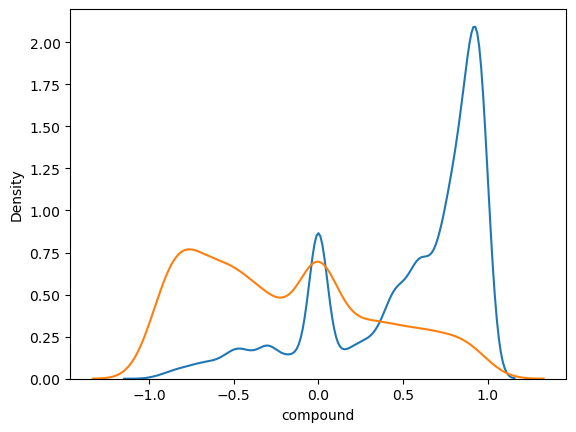

In \[23\]:

    label = "is_bad_review"
    ignore_cols = [label, "review", "review_clean"]
    features = [c for c in reviews_df.columns if c not in ignore_cols]

    # split the data into train and test
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

In \[24\]:

    rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
    rf.fit(X_train, y_train)

    # show feature importance
    feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
    feature_importances_df.head(20)

Out\[24\]:

|      | feature          | importance |
|------|------------------|------------|
| 3    | compound         | 0.036560   |
| 2    | pos              | 0.024932   |
| 0    | neg              | 0.022625   |
| 6    | doc2vec_vector_0 | 0.021495   |
| 8    | doc2vec_vector_2 | 0.019057   |
| 10   | doc2vec_vector_4 | 0.018143   |
| 9    | doc2vec_vector_3 | 0.017980   |
| 4    | nb_chars         | 0.017589   |
| 7    | doc2vec_vector_1 | 0.016628   |
| 1    | neu              | 0.015447   |
| 5    | nb_words         | 0.013918   |
| 950  | word_dirty       | 0.010396   |
| 2853 | word_room        | 0.009478   |
| 2239 | word_nothing     | 0.009457   |
| 285  | word_bad         | 0.008922   |
| 1945 | word_location    | 0.006801   |
| 3216 | word_star        | 0.006542   |
| 3202 | word_staff       | 0.006510   |
| 1639 | word_hotel       | 0.006489   |
| 2284 | word_old         | 0.006133   |

In \[25\]:

    # ROC curve

    from sklearn.metrics import roc_curve, auc, roc_auc_score
    import matplotlib.pyplot as plt

    y_pred = [x[1] for x in rf.predict_proba(X_test)]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

    roc_auc = auc(fpr, tpr)

    plt.figure(1, figsize = (15, 10))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

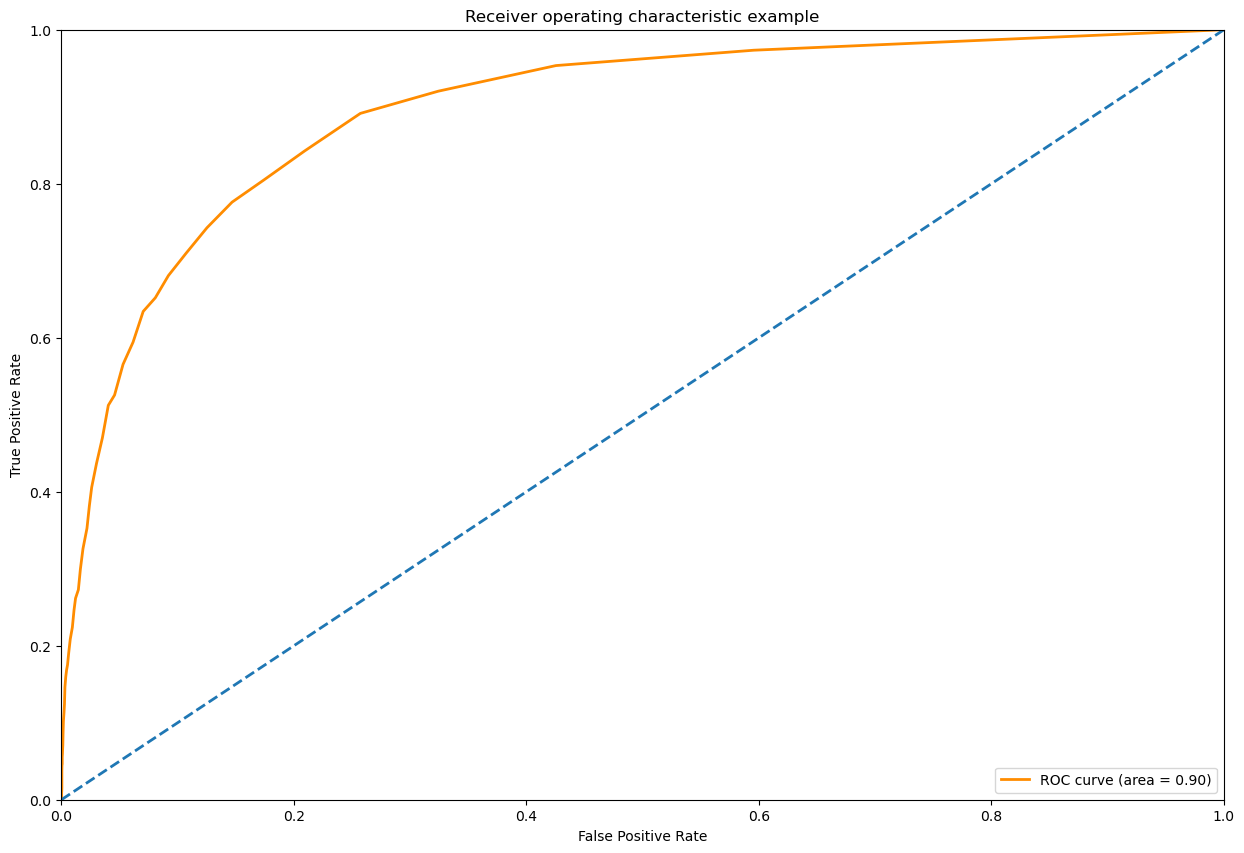

In \[27\]:

    from sklearn.metrics import average_precision_score, precision_recall_curve
    import matplotlib.pyplot as plt

    average_precision = average_precision_score(y_test, y_pred)

    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    plt.figure(1, figsize=(15, 10))
    plt.plot(recall, precision, color='b', alpha=0.2)
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

    plt.show()

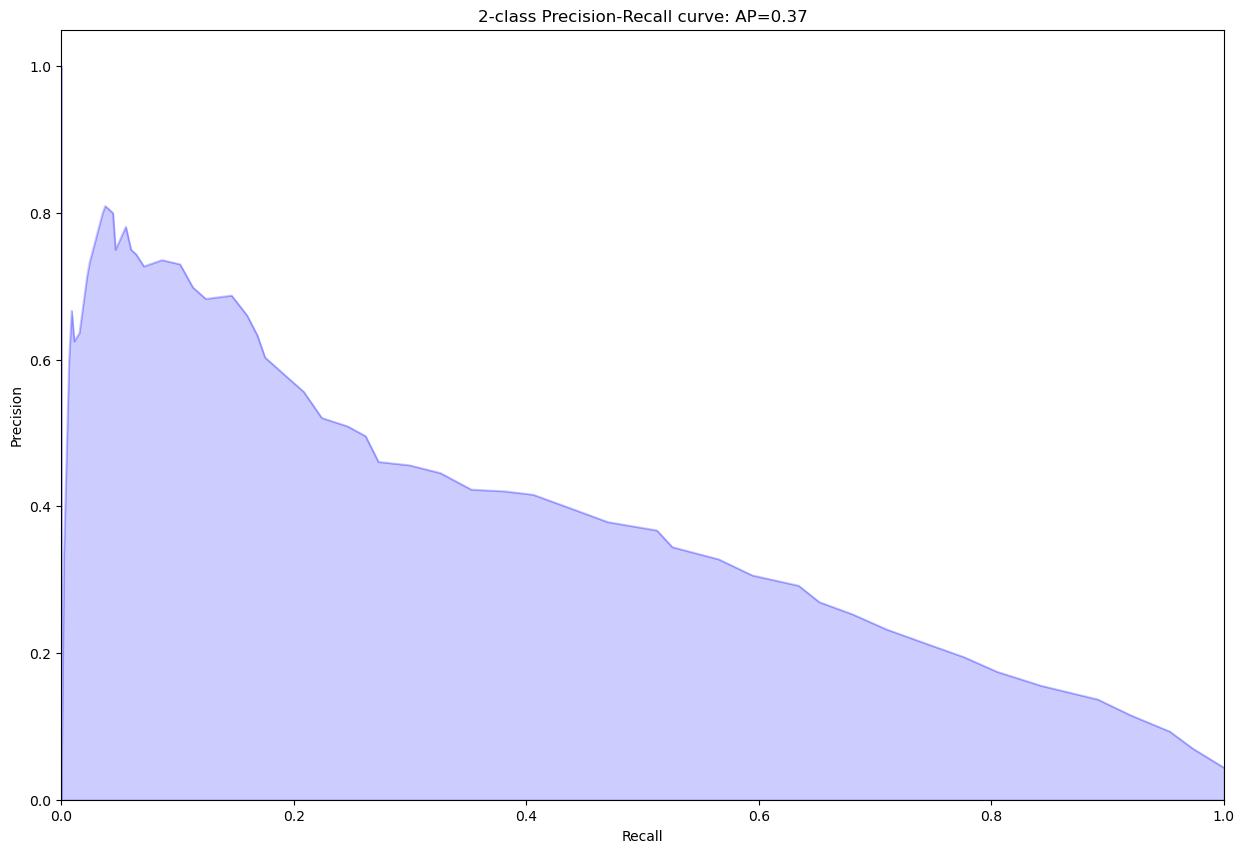

In \[ \]:

     

In \[29\]:

    #Conclusion

Using raw text as input for predictions is entirely feasible. The key is
to effectively extract pertinent features from this unprocessed data
source. Such data often serves as a valuable supplementary resource in
data science projects, enhancing the capacity to derive meaningful
features and boosting the predictive capabilities of models

In \[ \]: